In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import pickle
import os
from scipy.ndimage import gaussian_filter

plt.rcdefaults()

In [6]:
DATA_PATH = "MHD_data/dataset_pickle"
FILE_EXT = "pickle"


def load_shot(shotno, data_path, file_ext):
    file_path = os.path.join(data_path, f"{shotno}.{file_ext}")
    return pd.read_pickle(file_path)

In [7]:
# get all shot nos
all_shots = [int(os.path.basename(x.split(f".{FILE_EXT}")[0]))
             for x in glob.glob(os.path.join(DATA_PATH, f"*.{FILE_EXT}"))]
if len(all_shots) < 94:  # check if all data is there
    raise ValueError(f"Not all shots found in path /{DATA_PATH}/; found only {len(all_shots)} out of 94")

In [9]:
print(f"List of all shots/pulses:")
print(all_shots)

List of all shots/pulses:
[71292, 72966, 72196, 64820, 64648, 64394, 71226, 70394, 72198, 64658, 71300, 64646, 71259, 70388, 71224, 64662, 71193, 71255, 64670, 64770, 72964, 72919, 70380, 64392, 64774, 73018, 64778, 71189, 64678, 70392, 64666, 73022, 64650, 64834, 72927, 70357, 70355, 72925, 72929, 70359, 71222, 64664, 70390, 64668, 70382, 71265, 73020, 71256, 70387, 64673, 71182, 71190, 64649, 71260, 71303, 64374, 64680, 72967, 64378, 64401, 72920, 72965, 64682, 64376, 72930, 71192, 71225, 70389, 64389, 64647, 64659, 70356, 72926, 72961, 64686, 73023, 71266, 64675, 73019, 70381, 70393, 71188, 71264, 73021, 70391, 71194, 71223, 70383, 64677, 71186, 72959, 72928, 64684, 72963]


In [149]:
shotno = all_shots[30]
#shotno = 71265
data_shot = load_shot(shotno, DATA_PATH, FILE_EXT)

In [150]:
print(f"Example structure of shot #{shotno}:")


def explore_structure(data, indent=0):
    """Recursively prints the structure of nested dictionaries/lists."""
    if isinstance(data, dict):
        for key, value in data.items():
            print('  ' * indent + str(key))
            explore_structure(value, indent + 1)
    elif isinstance(data, list):
        if len(data) > 0:
            print('  ' * indent + f'List of {len(data)} items - showing type of first item')
            explore_structure(data[0], indent + 1)
        else:
            print('  ' * indent + 'Empty List')
    elif isinstance(data, np.ndarray):
        print('  ' * indent + f'NumPy Array - shape: {data.shape}, dtype: {data.dtype}')
    else:
        print('  ' * indent + f'{type(data)}')


#explore_structure(data_shot)
#data_shot['x']['spectrogram']['OddN'].mean()

Example structure of shot #64666:


In [169]:
# Extracting inputs
inputs = data_shot["x"]["spectrogram"]
spec_even = inputs["EvenN"]
spec_odd = inputs["OddN"]
f = inputs["frequency"]
t = inputs["time"]


# Function to plot spectrogram
def plot_spectrogram(spec, title, time, frequency, start_longest_mode=None, end_longest_mode=None):
    fig, ax = plt.subplots()
    ax.imshow(spec.T, extent=(time[0], time[-1], frequency[0], frequency[-1]), aspect='auto', cmap='jet',
              origin='lower')
    ax.set_xlim(time[0], time[-1])
    ax.set_ylim(frequency[0], frequency[-1])
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Frequency [Hz]")
    fig.set_dpi(150)
    plt.title(title)
    
    # Plot vertical lines if start and end times are provided
    if start_longest_mode is not None and end_longest_mode is not None:
        ax.axvline(x=start_longest_mode, color='blue', linestyle='--', label='Start of Longest Mode')
        ax.axvline(x=end_longest_mode, color='cyan', linestyle='--', label='End of Longest Mode')
        plt.legend()
    
    plt.show()

In [170]:
#plot_spectrogram(spec_odd, "Odd N", t, f)
#plot_spectrogram(spec_even, "Even N", t, f)

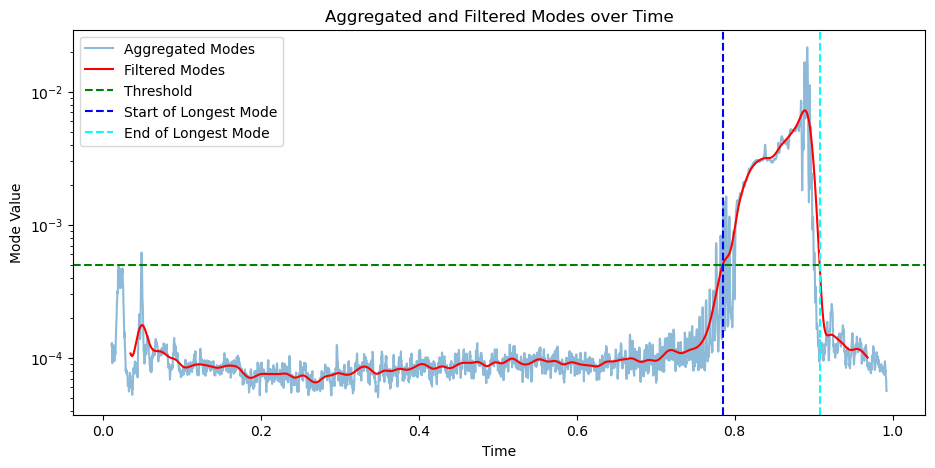

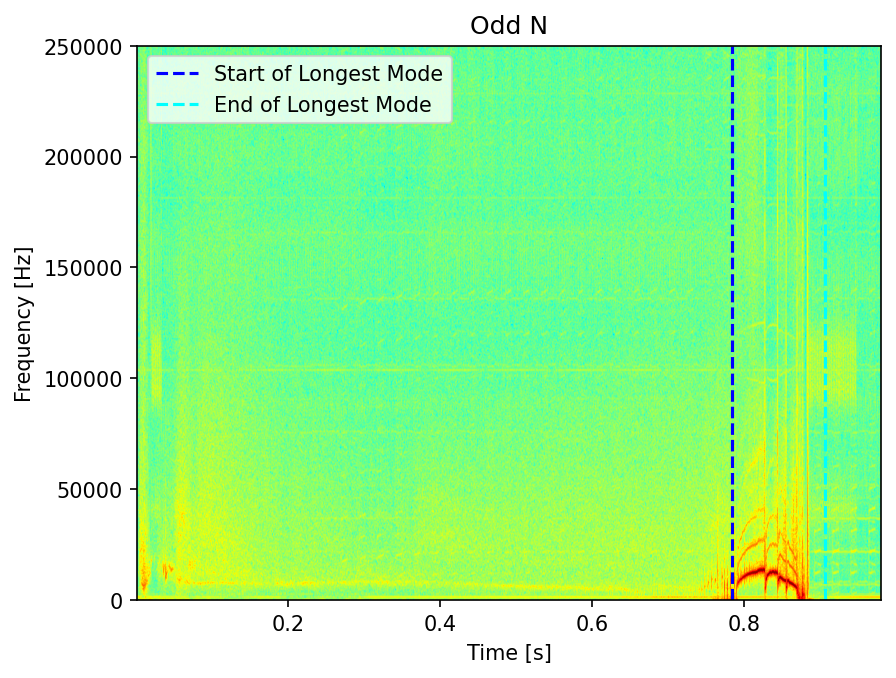

In [182]:
def plot_aggregated_modes(label_sources, mode_thresh=0.0005):
    # Aggregating modes
    modes = np.sum(np.stack([label_sources[f"N{i}"] for i in range(5)]), axis=0)  #+ label_sources["LM"]
    time = label_sources["time"]

    # Applying Gaussian filter
    filtered_modes = gaussian_filter(modes, sigma=30)

    # Find the longest mode segment above the threshold
    above_threshold = filtered_modes > mode_thresh
    change_points = np.diff(above_threshold).nonzero()[0] + 1
    if above_threshold[0]:
        change_points = np.insert(change_points, 0, 0)
    if above_threshold[-1]:
        change_points = np.append(change_points, len(above_threshold))

    segment_lengths = change_points[1::2] - change_points[::2]
    if len(segment_lengths) > 0:
        longest_segment_index = np.argmax(segment_lengths)
        start_longest_mode = time[change_points[2 * longest_segment_index]]
        end_longest_mode = time[change_points[2 * longest_segment_index + 1]]

    # Plotting
    plt.figure(figsize=(11, 5))
    plt.plot(time, modes, label='Aggregated Modes', alpha=0.5)
    plt.plot(time, filtered_modes, label='Filtered Modes', color='red')
    plt.axhline(y=mode_thresh, color='green', linestyle='--', label='Threshold')
    plt.xlabel('Time')
    plt.ylabel('Mode Value')
    plt.title('Aggregated and Filtered Modes over Time')
    plt.yscale('log')

    # Highlight the longest mode segment
    if len(segment_lengths) > 0:
        plt.axvline(x=start_longest_mode, color='blue', linestyle='--', label='Start of Longest Mode')
        plt.axvline(x=end_longest_mode, color='cyan', linestyle='--', label='End of Longest Mode')
    
    plt.legend()
    plt.show()
    
    return start_longest_mode, end_longest_mode

slm, elm = plot_aggregated_modes(data_shot['y']['modes'])
plot_spectrogram(spec_odd, "Odd N", t, f, slm, elm)

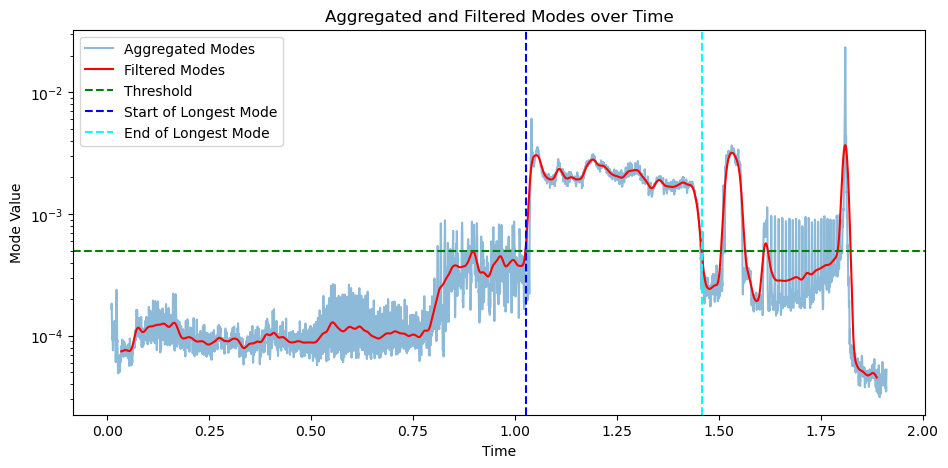

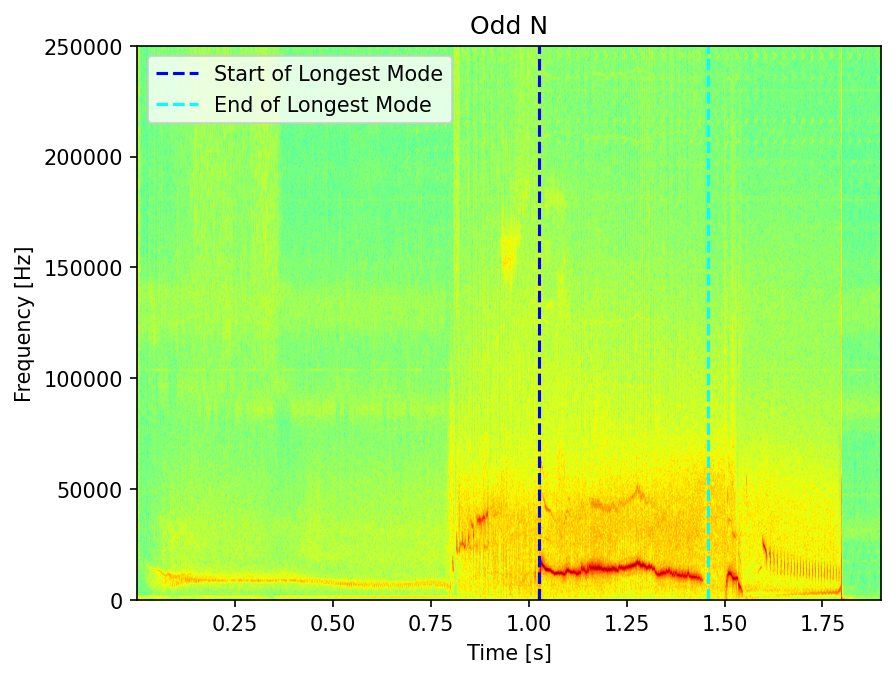

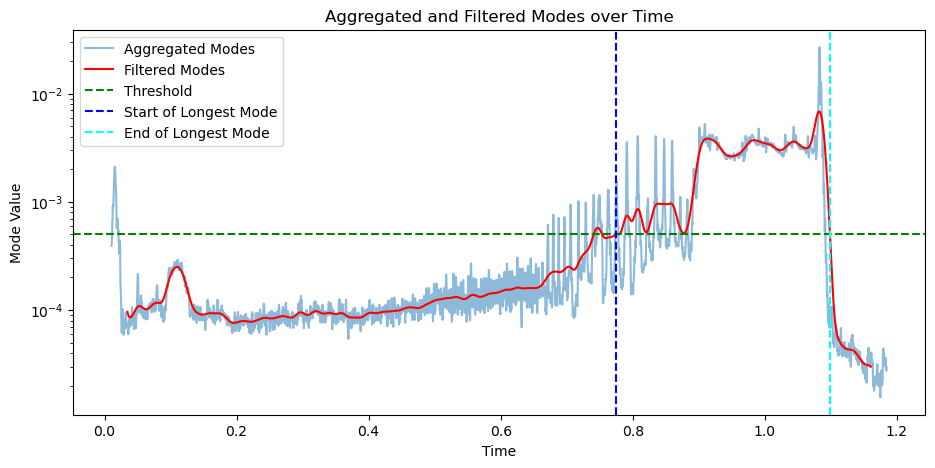

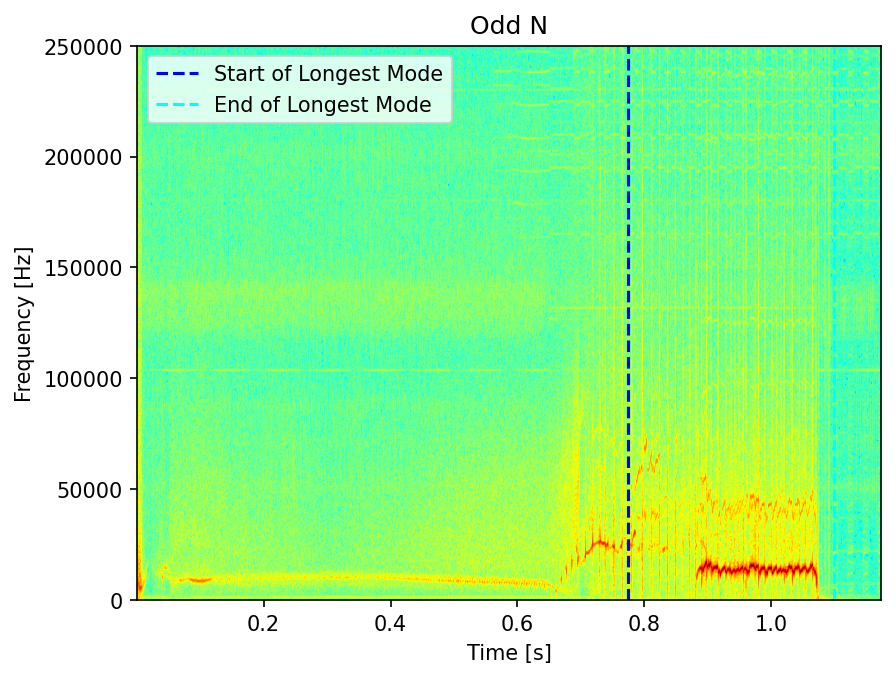

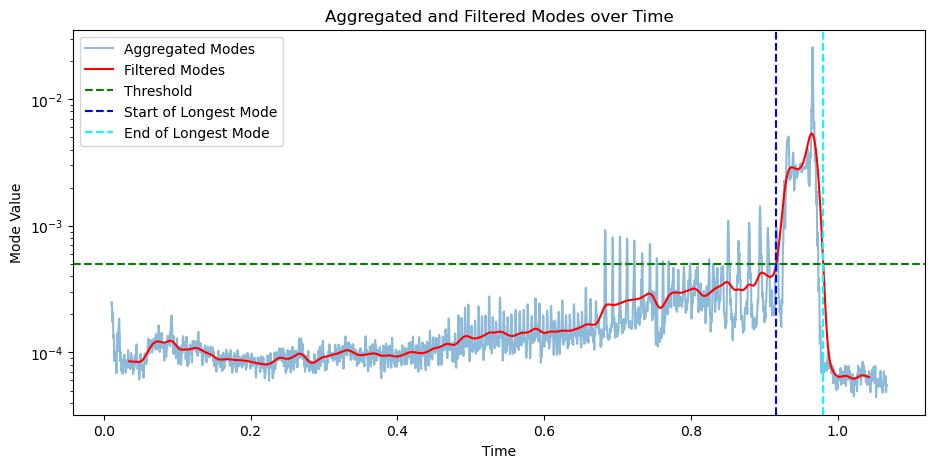

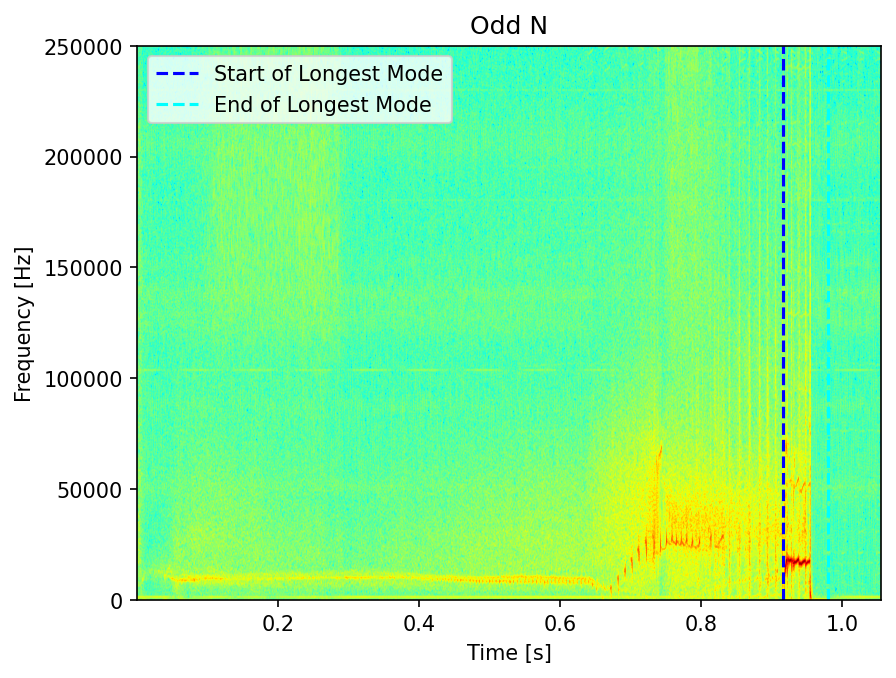

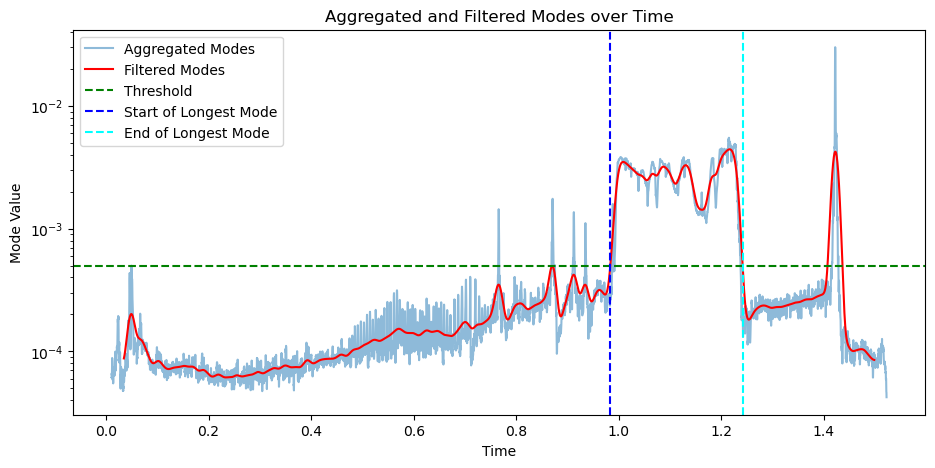

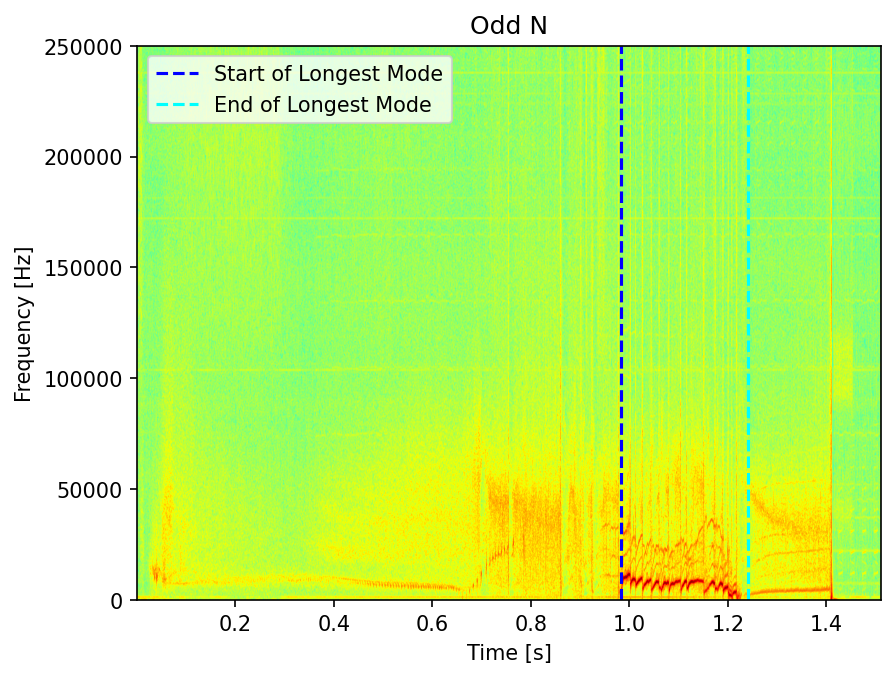

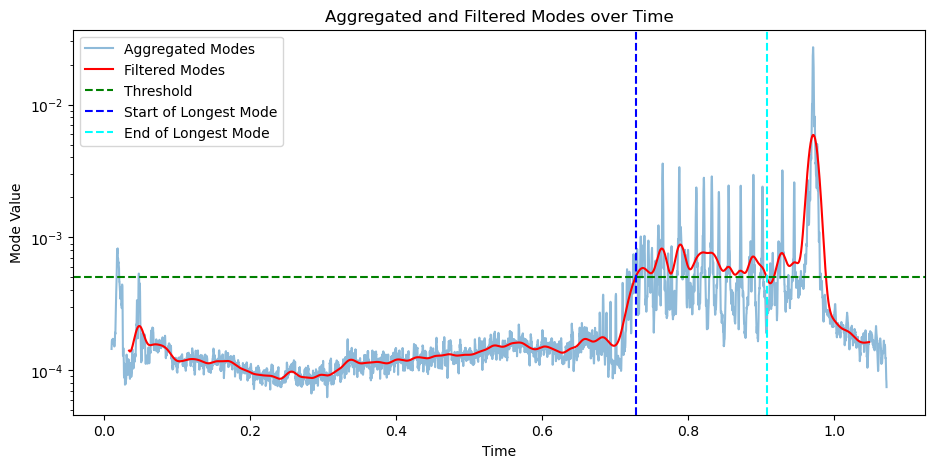

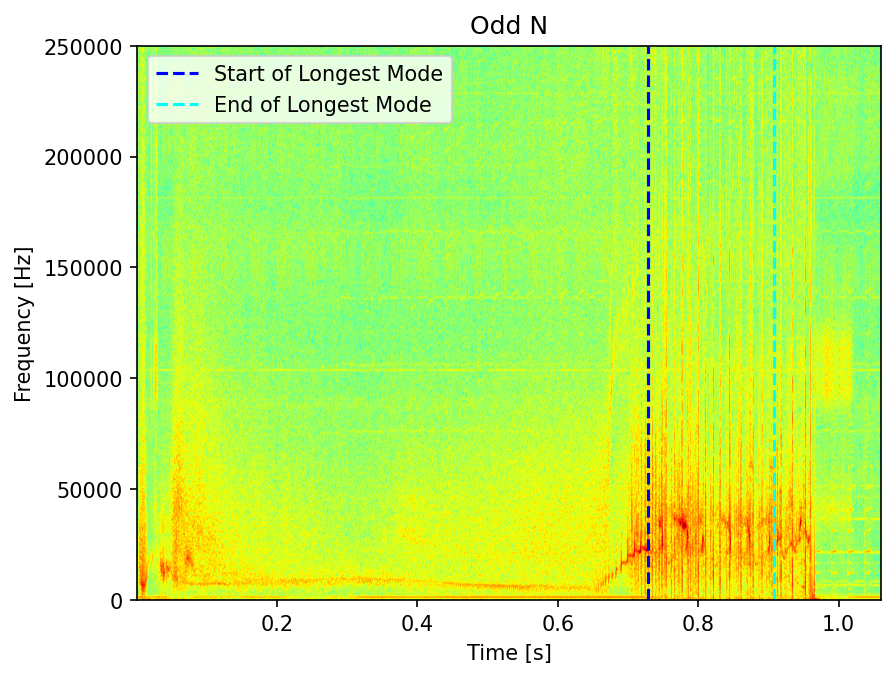

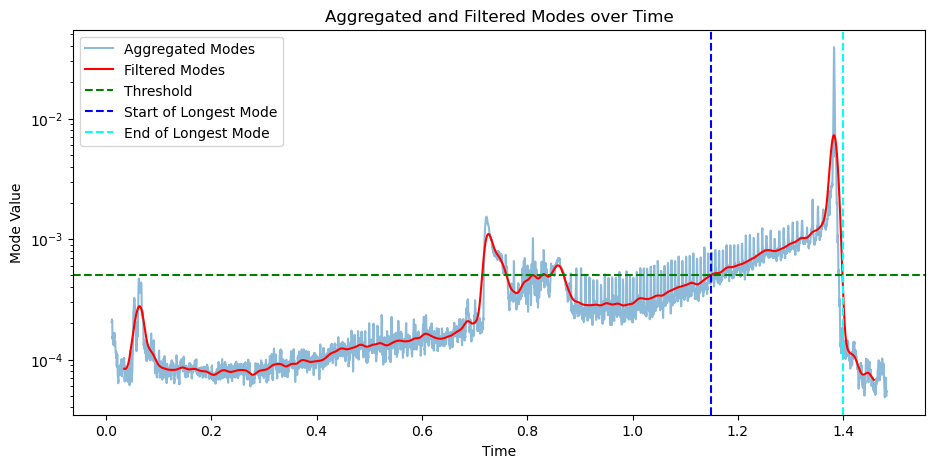

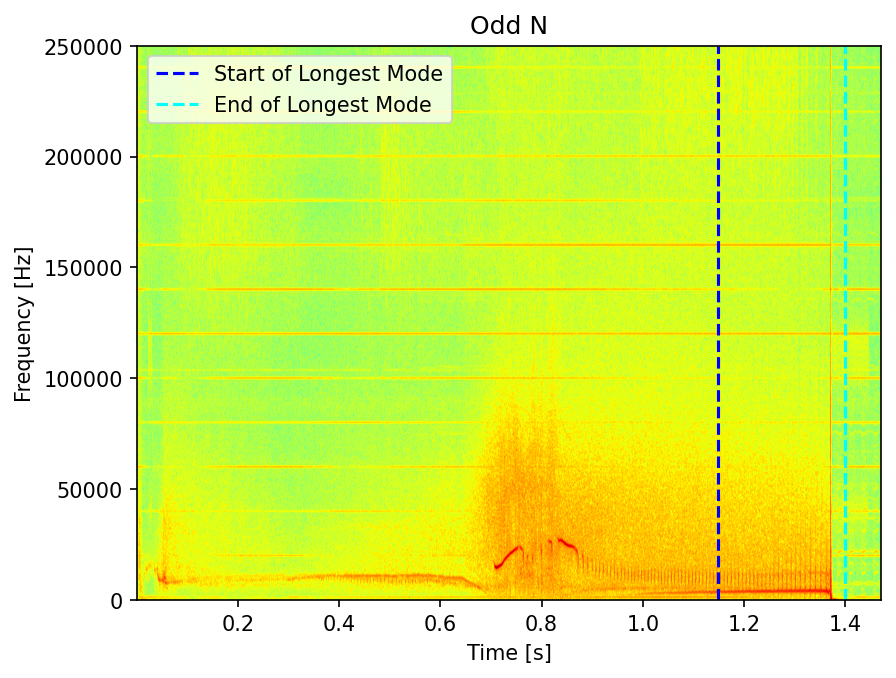

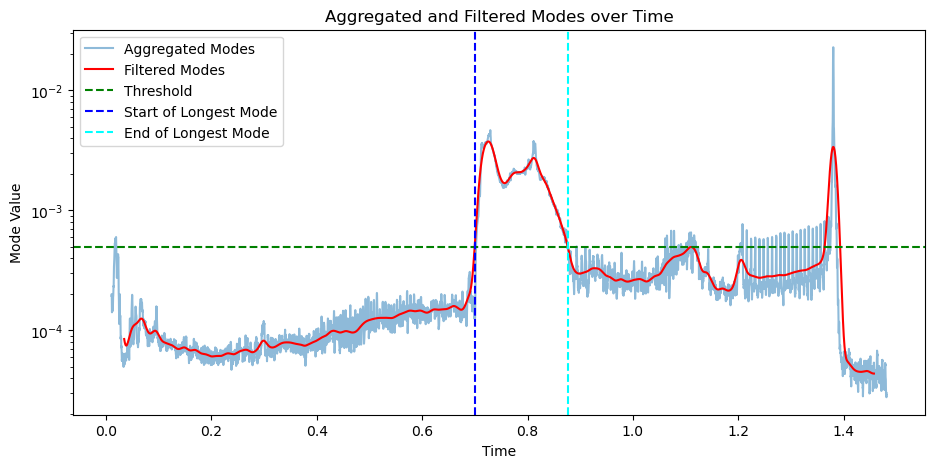

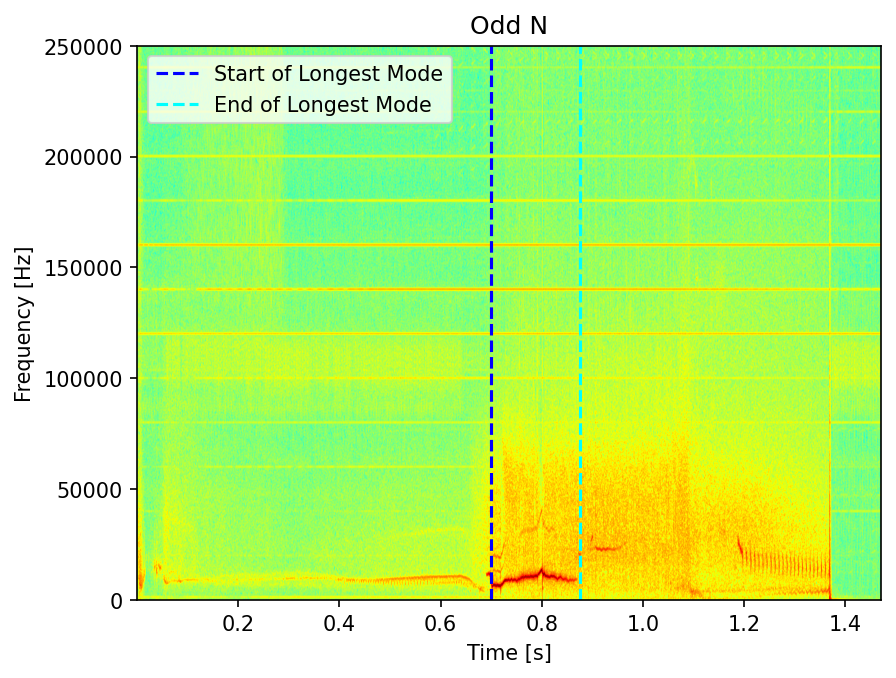

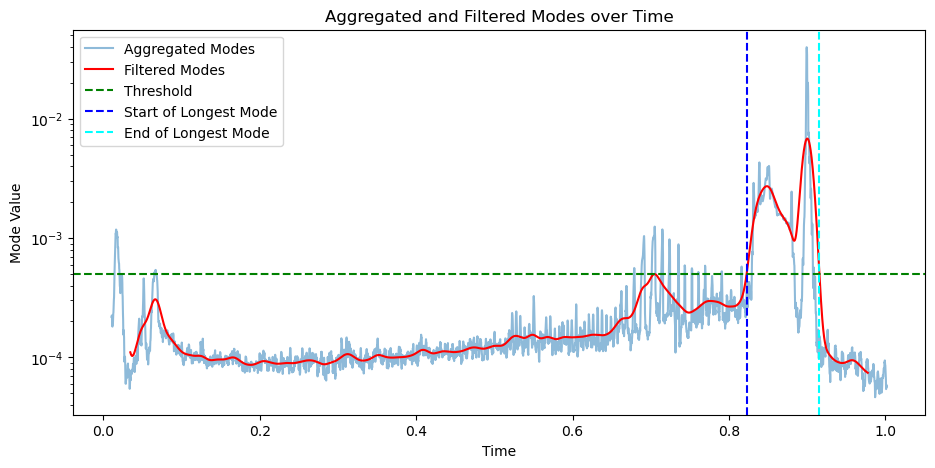

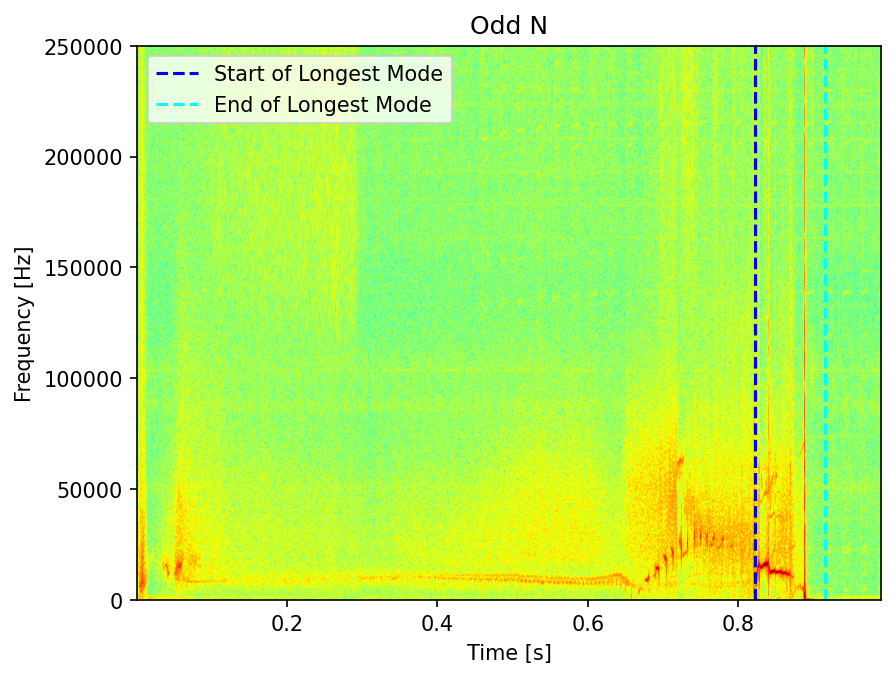

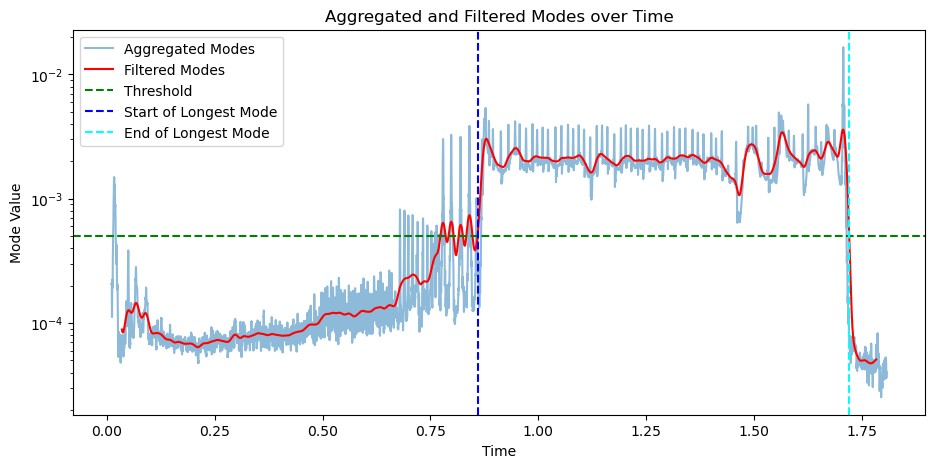

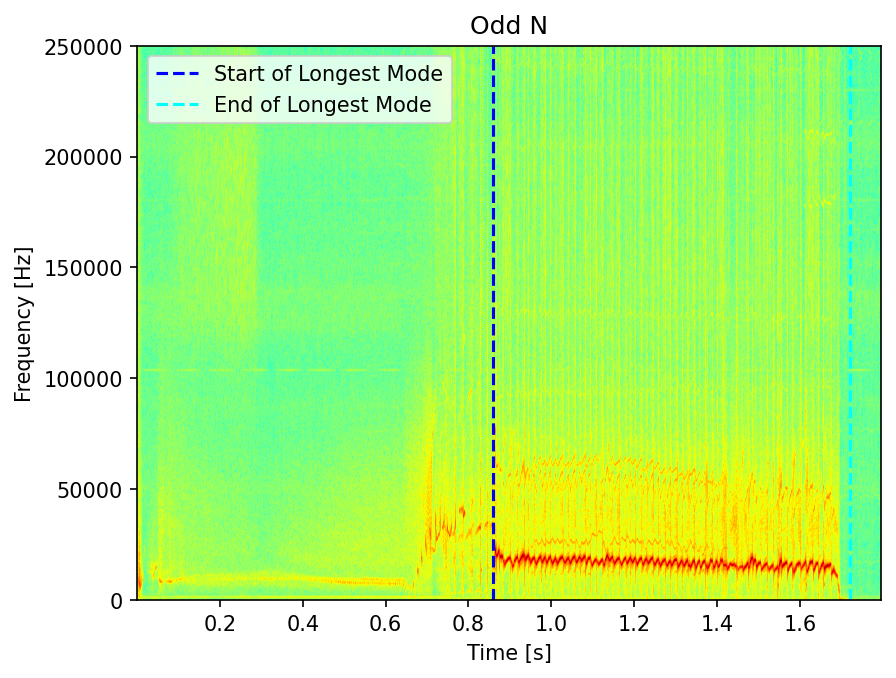

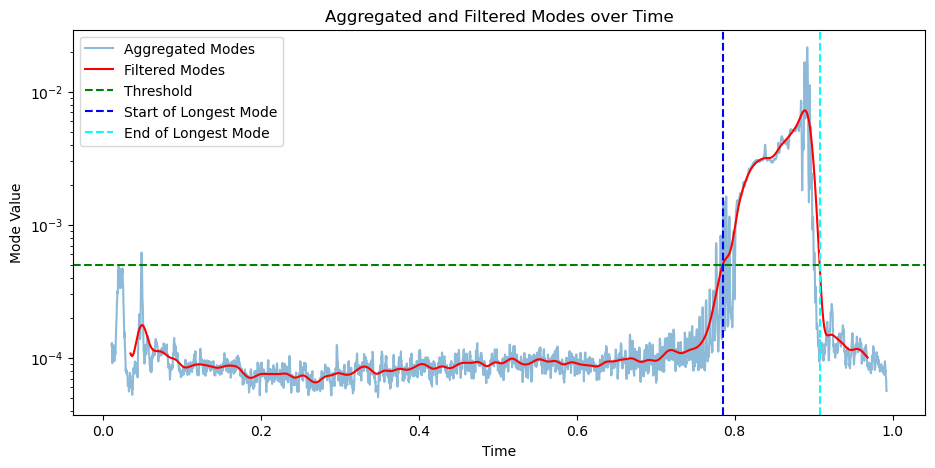

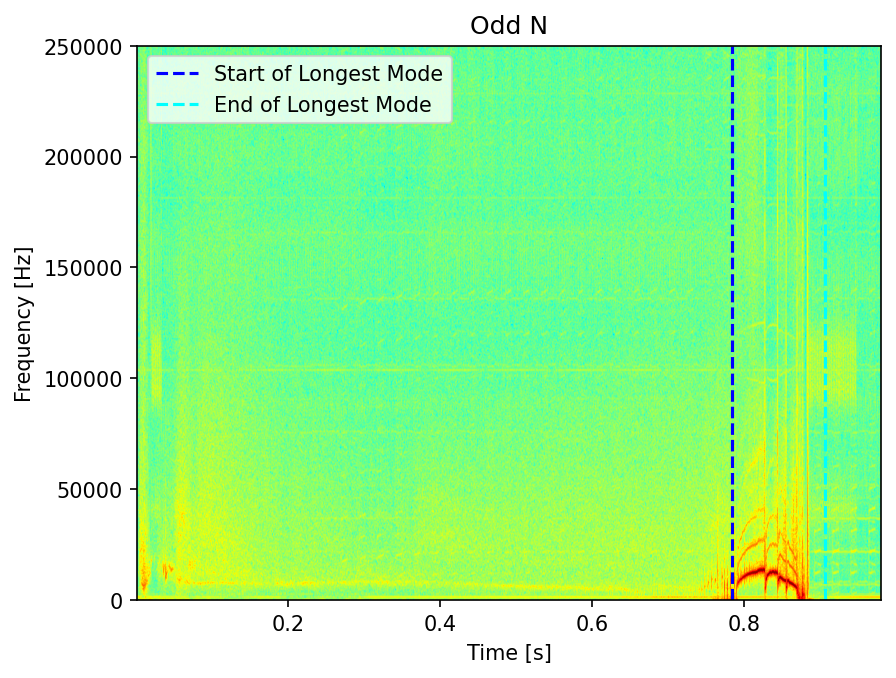

In [184]:
for shotno in all_shots[:10]:
    data_shot = load_shot(shotno, DATA_PATH, FILE_EXT)
    inputs = data_shot["x"]["spectrogram"]
    spec_odd = inputs["OddN"]
    f = inputs["frequency"]
    t = inputs["time"]
    
    slm, elm = plot_aggregated_modes(data_shot['y']['modes'], mode_thresh=0.0005)
    plot_spectrogram(spec_odd, "Odd N", t, f, slm, elm)